# Buy Till You Die Models: Customer Lifetime Value

Import Packages and Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lifetimes.plotting import *
from lifetimes.utils import *

from lifetimes import GammaGammaFitter
from lifetimes import ModifiedBetaGeoFitter

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

from lifetimes.utils import calculate_alive_path

from lifetimes.utils import calibration_and_holdout_data

from datetime import date
from lifetimes.plotting import plot_history_alive
from pylab import figure, text, scatter, show

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import dataset 

In [19]:
df = pd.read_excel("online_retail_II.xlsx",sheet_name="Year 2010-2011", engine = 'openpyxl')

In [4]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [21]:
df.describe().T # descriptive statistics of numerical variables

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0,9.552234,218.080957,-80995.00,1.00,3.00,10.00,80995.0
Price,541910.0,4.611138,96.759765,-11062.06,1.25,2.08,4.13,38970.0
Customer ID,406830.0,15287.684160,1713.603074,12346.00,13953.00,15152.00,16791.00,18287.0


when we check the descriptive statistics of variables, we observe some negative values on quantity and price colums, we are going to drop these raws later. Customer ID should be also object type.

In [22]:
df.isnull().sum() #check the missing values

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

# Data Preprocessing

In [23]:
 #drop the rows have missing Customer ID
df = df[df['Customer ID'].notna()]  

 #drop the canceled orders 
df = df[(df['Quantity'] > 0)]       


#drop unnecessary columns
df.drop(['Description','Country'], axis= 1, inplace= True) 

In [24]:
df['Total_Sales'] = df['Quantity'] * df['Price']
df['Customer ID'] = df['Customer ID'].astype(str)

In [31]:
df['InvoiceDate2'] = df['InvoiceDate'].dt.date
df['InvoiceDate2']

0         2010-12-01
1         2010-12-01
2         2010-12-01
3         2010-12-01
4         2010-12-01
             ...    
541905    2011-12-09
541906    2011-12-09
541907    2011-12-09
541908    2011-12-09
541909    2011-12-09
Name: InvoiceDate2, Length: 397925, dtype: object

In [32]:
df['InvoiceDate2'].max()

datetime.date(2011, 12, 9)

Outlier Analysis if its appropriate----------------------------

# RFM analysis for CLTV modelling

In [34]:
rfm_pre = df[['Customer ID','InvoiceDate2','Total_Sales']]

In [35]:
# Get the format into the required Frequency, Recency and T (age) using the lifetimes library
rfm_summary = calibration_and_holdout_data(rfm_pre,
                                          customer_id_col = 'Customer ID',
                                          datetime_col = 'InvoiceDate2',
                                          monetary_value_col = 'Total_Sales',
                                          calibration_period_end = '2011-09-10',
                                          observation_period_end = '2011-12-09')

In [36]:
rfm_summary.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
Customer ID,,,,,,,
12346.0,0.0,0.0,235.0,0.0000,0.0,0.000000,90.0
12347.0,4.0,238.0,277.0,519.7675,2.0,26.192069,90.0
12348.0,2.0,110.0,268.0,297.2200,1.0,103.333333,90.0
12350.0,0.0,0.0,220.0,0.0000,0.0,0.000000,90.0
12352.0,3.0,34.0,206.0,421.7700,3.0,20.090000,90.0


# Build and Fit BG-NBD Model (Expected number of transaction)

In [37]:
from lifetimes import ModifiedBetaGeoFitter

bgnbd = ModifiedBetaGeoFitter(penalizer_coef = 0.01)

bgnbd.fit(rfm_summary['frequency_cal'],
         rfm_summary['recency_cal'],
         rfm_summary['T_cal'],
         verbose = True)

Optimization terminated successfully.
         Current function value: -1.356756
         Iterations: 41
         Function evaluations: 42
         Gradient evaluations: 42


<lifetimes.ModifiedBetaGeoFitter: fitted with 3370 subjects, a: 0.00, alpha: 62.46, b: 0.00, r: 0.69>

Modified Beta Geo fitter (MBG) is given a parameter penalizer_coef which is applied on the L2 norm or Euclidean norm. 

In [38]:
t = 90
rfm_summary['predicted_purchases'] = bgnbd.conditional_expected_number_of_purchases_up_to_time(t,
                                                                                              rfm_summary['frequency_cal'],
                                                                                              rfm_summary['recency_cal'],
                                                                                              rfm_summary['T_cal'])
rfm_summary['p_alive'] = bgnbd.conditional_probability_alive(rfm_summary['frequency_cal'],
                                                             rfm_summary['recency_cal'],
                                                             rfm_summary['T_cal'])

In [39]:
display(rfm_summary.sample(5))

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,predicted_purchases,p_alive
Customer ID,,,,,,,,,
16600.0,1.0,85.0,248.0,111.60,4.0,13.092273,90.0,0.488564,1.0
16344.0,0.0,0.0,68.0,0.00,0.0,0.000000,90.0,0.472786,1.0
13239.0,0.0,0.0,171.0,0.00,0.0,0.000000,90.0,0.264198,1.0
14600.0,0.0,0.0,215.0,0.00,0.0,0.000000,90.0,0.222301,1.0
13192.0,1.0,110.0,115.0,447.62,0.0,0.000000,90.0,0.854727,1.0


Gamma-Gamma assumes that there is no relationship between the monetary value and the purchase frequency. For that, we need to check it by using the Pearsons’ correlation test.

In [40]:
returned_customers_rfm_summary = rfm_summary[rfm_summary['frequency_cal'] > 0]
returned_customers_rfm_summary[['monetary_value_cal','frequency_cal']].corr()

,monetary_value_cal,frequency_cal
monetary_value_cal,1.000000,0.105329
frequency_cal,0.105329,1.000000


# Build and Fit Gamma Gamma Model (Expected average spending)

In [41]:
from lifetimes import GammaGammaFitter

gg = GammaGammaFitter(penalizer_coef = 0.01)
gg.fit(returned_customers_rfm_summary['frequency_cal'],
      returned_customers_rfm_summary['monetary_value_cal'],
      verbose = True)
gg.summary

Optimization terminated successfully.
         Current function value: 8.049980
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13


,coef,se(coef),lower 95% bound,upper 95% bound
p,3.765928,0.115437,3.539672,3.992185
q,0.336334,0.008619,0.319441,0.353228
v,3.643351,0.116991,3.414049,3.872653


Using the gamma-gamma fitter model we will now predict the CLTV for customers

In [42]:
rfm_summary['cltv'] = gg.customer_lifetime_value(bgnbd,
                                                rfm_summary['frequency_cal'],
                                                rfm_summary['recency_cal'],
                                                rfm_summary['T_cal'],
                                                rfm_summary['monetary_value_cal'],
                                                time = 3, #months
                                                discount_rate = 0)

rfm_summary['cltv'] += -1*rfm_summary['cltv'].min()



In [68]:
rfm_summary.sort_values("cltv", ascending=False).head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,predicted_purchases,p_alive,cltv
Customer ID,,,,,,,,,,
14646.0,29.0,262.0,264.0,6145.919310,15.0,145.368616,90.0,8.183798,1.0,50625.607905
18102.0,15.0,269.0,277.0,7302.025333,10.0,463.457276,90.0,4.158608,1.0,30748.381227
12415.0,11.0,238.0,247.0,8643.318182,4.0,198.492609,90.0,3.398439,1.0,29873.279536
14156.0,30.0,278.0,281.0,3284.538000,12.0,93.541869,90.0,8.040769,1.0,26587.347443
17450.0,16.0,272.0,277.0,5277.043750,10.0,720.595000,90.0,4.423736,1.0,23625.342816


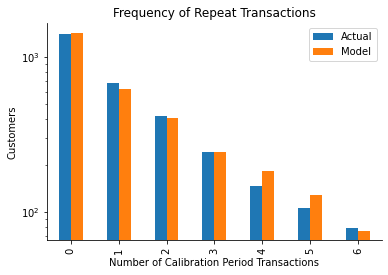

In [44]:
from lifetimes.plotting import plot_period_transactions

ax = plot_period_transactions(bgnbd, max_frequency = 7)
ax.set_yscale('log')
sns.despine();

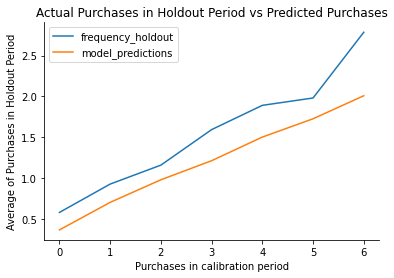

In [45]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(bgnbd, rfm_summary)
sns.despine();

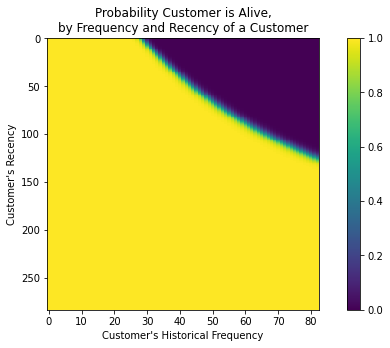

In [69]:
%matplotlib inline
# set figure size
plt.subplots(figsize=(10, 5))
plot_probability_alive_matrix(bgnbd)
plt.show()

In [47]:
#Describing the particulars of the customers and initializing the total number of time units, 
#defining the future date and past date for plotting the history.

individual = rfm_summary.iloc[1]

id = individual.name
t = 365*5

today = date.today()
two_years_ago = today.replace(year = today.year - 2)
one_year_from_now = today.replace(year = today.year + 1)

sp_trans = rfm_pre.loc[rfm_pre['Customer ID'] == id]

In [50]:
t = (today - sp_trans.InvoiceDate2.min()).days
p_alive_today = pd.DataFrame(calculate_alive_path(bgnbd, 
                                                  sp_trans, 
                                                  'InvoiceDate2', 
                                                  t, 
                                                  freq = 'D'))[0].tail(1).values
p_alive_today = np.round(p_alive_today[0],2)
print('Probability that customer is still alive today is', p_alive_today)

Probability that customer is still alive today is [1.]


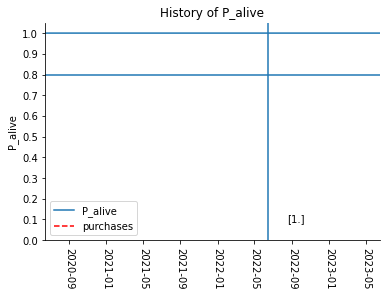

In [52]:
t = (one_year_from_now - sp_trans.InvoiceDate2.min()).days
ax = plot_history_alive(bgnbd, 
                        t, 
                        sp_trans, 
                        'InvoiceDate2', 
                        start_date = two_years_ago)

ax.vlines(x = today, ymin = 0, ymax = 1.05)
ax.hlines(y=0.8, xmin = two_years_ago, xmax = one_year_from_now)

ax.set_xlim(two_years_ago, one_year_from_now) 
ax.set_ylim(0, 1.05)
 
plt.xticks(rotation =-90)
text(0.75, 0.1, p_alive_today, ha = 'center', va = 'center', transform = ax.transAxes)
sns.despine()

# Effect of time on prediction of transactions

In [55]:
rfm_pre = pd.DataFrame(data = rfm_pre, columns = ['Customer ID', 'InvoiceDate2'])

In [59]:

time_unit = (rfm_pre.InvoiceDate2.max() - rfm_pre.InvoiceDate2.min()).days
df2 = expected_cumulative_transactions(bgnbd, rfm_pre, 'InvoiceDate2', 'Customer ID', time_unit)
df2.head()

,actual,predicted
0,0,1.042372
1,6,3.105172
2,10,5.672699
3,10,8.240226
4,16,11.564845


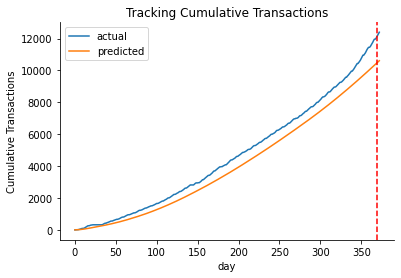

In [67]:
cal = datetime.strptime('2011-12-05', '%Y-%m-%d')
 
from lifetimes.plotting import plot_cumulative_transactions

time_unit = (rfm_pre.InvoiceDate2.max() - rfm_pre.InvoiceDate2.min()).days
time_unit_cal = (cal.date() - rfm_pre.InvoiceDate2.min()).days
plot_cumulative_transactions(bgnbd, rfm_pre, 'InvoiceDate2', 'Customer ID', time_unit, time_unit_cal, freq='D')
sns.despine()